In [ ]:
!pip install wget

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 5.3 MB/s 
     |████████████████████████████████| 596 kB 40.2 MB/s 
     |████████████████████████████████| 6.5 MB 36.6 MB/s 
     |████████████████████████████████| 895 kB 48.6 MB/s 
     |████████████████████████████████| 67 kB 5.8 MB/s 


In [ ]:
import os
import sys
import wget 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
if torch.cuda.is_available():     
    device = torch.device("cuda")
    print("GPU is available!")
else:
    device = torch.device("cpu")

GPU is available!


Data               | Task                                      | Metric
-------------------|-------------------------------------------|----------------
CoLA               | Sentence is grammatical or not grammatical|Matthews
SST-2              | Review is positive negative or neutral    |Accuracy
RTE                | Sentence 1 -> Sentence 2?                 |Accuracy

## Data preprocessing 

In [ ]:
cola_link = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'
wget.download(cola_link, './cola_public_1.1.zip')

'./cola_public_1.1.zip'

In [ ]:
!unzip cola_public_1.1.zip

Archive:  cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_public/raw/out_of_domain_dev.tsv  


In [ ]:
cola_data_t = pd.read_csv("/content/cola_public/tokenized/in_domain_train.tsv", delimiter="\t", names=['sentence_source', 'label', 'label_notes', 'sentence'], index_col=False)
print("Total of train sentences", cola_data_t.shape[0])
print("Sample of tokenized sentence: ", cola_data_t["sentence"][0])
cola_data_t.head(5)

Total of train sentences 8551
Sample of tokenized sentence:  our friends wo n't buy this analysis , let alone the next one we propose .


,sentence_source,label,label_notes,sentence
0,gj04,1,NaN,"our friends wo n't buy this analysis , let alo..."
1,gj04,1,NaN,one more pseudo generalization and i 'm giving...
2,gj04,1,NaN,one more pseudo generalization or i 'm giving ...
3,gj04,1,NaN,"the more we study verbs , the crazier they get ."
4,gj04,1,NaN,day by day the facts are getting murkier .


In [ ]:
cola_data_t = cola_data_t[["sentence", "label"]]
cola_data_t.head()

,sentence,label
0,"our friends wo n't buy this analysis , let alo...",1
1,one more pseudo generalization and i 'm giving...,1
2,one more pseudo generalization or i 'm giving ...,1
3,"the more we study verbs , the crazier they get .",1
4,day by day the facts are getting murkier .,1


In [ ]:
train_cola_data, test_cola_data, train_cola_labels, test_cola_labels = train_test_split(cola_data_t["sentence"], cola_data_t["label"], train_size=0.8)

In [ ]:
#train_cola_data, test_cola_data, train_cola_labels, test_cola_labels = train_test_split(cola_data["sentence"], cola_data["label"])

In [ ]:
print(train_cola_data.shape)
print(test_cola_data.shape)
print(train_cola_labels.shape)
print(test_cola_labels.shape)

(6840,)
(1711,)
(6840,)
(1711,)


## Baseline - BERT with default parameters as a feature extractor, Logistic Regression as a classifier

In [ ]:
def load_model(model_class, tokenizer_class, weights):
    tokenizer = tokenizer_class.from_pretrained(weights)
    model = model_class.from_pretrained(weights)
    return model, tokenizer

In [ ]:
model, tokenizer = load_model(ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')
model.eval()
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
tokenized_train = train_cola_data.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
tokenized_test = test_cola_data.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [ ]:
def add_padding(tokenized_data):
    max_len = max([len(line) for line in tokenized_data.values])
    padded_data = np.array([line + [0] * (max_len - len(line)) for line in tokenized_data.values])
    #print(padded_cola_data.shape)
    return padded_data

In [ ]:
# padding
padded_train_data = add_padding(tokenized_train)
print(padded_train_data.shape)
# attention mask
mask_train = (padded_train_data > 0).astype(int)
print(mask_train.shape)

In [ ]:
# padding
padded_test_data = add_padding(tokenized_test)
print(padded_test_data.shape)
# attention mask
mask_test = (padded_test_data > 0).astype(int)
print(mask_test.shape)

(1711, 37)
(1711, 37)


In [ ]:
extracted_features_train = []
batch_size = 128
N = len(padded_train_data)
for i in range(0, N, batch_size):
    x_batch = torch.tensor(padded_train_data[i:i+batch_size]).to(device)
    mask_batch = torch.tensor(mask_train[i:i+batch_size]).to(device)

    # extract last hidden states to constuct feature matrix
    with torch.no_grad():
        batch_features = model(x_batch, attention_mask=mask_batch)[0][:, 0, :].cpu().numpy()
        extracted_features_train.append(batch_features)

In [ ]:
extracted_features_test = []
batch_size = 128
N = len(padded_test_data)
for i in range(0, N, batch_size):
    x_batch = torch.tensor(padded_test_data[i:i+batch_size]).to(device)
    mask_batch = torch.tensor(mask_test[i:i+batch_size]).to(device)

    # extract last hidden states to construct feature matrix
    with torch.no_grad():
        batch_features = model(x_batch, attention_mask=mask_batch)[0][:, 0, :].cpu().numpy()
        extracted_features_test.append(batch_features)

In [ ]:
train_features = np.vstack(extracted_features_train)
test_features = np.vstack(extracted_features_test)

In [ ]:
print(train_features.shape)

(6840, 768)


Default Logistic Regression

In [ ]:
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer

In [ ]:
clf_model = LogisticRegression()
clf_model.fit(train_features, train_cola_labels)
pred_labels = clf_model.predict(train_features)
pred_labels_test = clf_model.predict(test_features)

In [ ]:
print(matthews_corrcoef(train_cola_labels, pred_labels))
print(matthews_corrcoef(test_cola_labels, pred_labels_test))

0.534427366046026
0.38265855132679216


Normalized data + GridSearch (scoring for matthews correlation coef) 

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_features)
scaled_test = scaler.transform(test_features)

In [ ]:
param_grid = {'C': [1e-3, 1e-2, 1e-1, 1, 10, 100]}
scorer = make_scorer(matthews_corrcoef)
grid_search = GridSearchCV(LogisticRegression(), param_grid, scoring=scorer, refit=True)
grid_search.fit(scaled_train, train_cola_labels)

print('best C parameter: ', grid_search.best_params_)

best C parameter:  {'C': 0.01}


In [ ]:
clf_model = LogisticRegression(C=0.01)
clf_model.fit(scaled_train, train_cola_labels)
pred_labels = clf_model.predict(scaled_train)
pred_labels_test = clf_model.predict(scaled_test)

In [ ]:
print(matthews_corrcoef(train_cola_labels, pred_labels))
print(matthews_corrcoef(test_cola_labels, pred_labels_test))

0.5214257478706297
0.4089498908572961


## Custom Classifier

In [ ]:
train_features = torch.tensor(train_features)
train_labels = torch.tensor(train_cola_labels.values)
train_dataset = TensorDataset(train_features, train_labels)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)

In [ ]:
test_features = torch.tensor(test_features)
test_labels = torch.tensor(test_cola_labels.values)
test_dataset = TensorDataset(test_features, test_labels)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:
class CustomClassifier(nn.Module):
    def __init__(self):
        super(CustomClassifier, self).__init__()
        self.lin1 = nn.Linear(768, 128)
        self.lin2 = nn.Linear(128, 32)
        self.lin3 = nn.Linear(32, 2)

    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        output = self.lin3(x)
        return F.log_softmax(output)

In [ ]:
model = CustomClassifier()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

hist = []

# training cycle
for t in range(30):
    for x_batch, labels_batch in train_loader:
        optimizer.zero_grad()
        preds = model(x_batch)
        loss = loss_fn(preds, labels_batch)
        loss.backward()
        optimizer.step()
    print(loss)
    hist.append(loss.detach()) 

tensor(0.5222, grad_fn=<NllLossBackward0>)
tensor(0.4930, grad_fn=<NllLossBackward0>)
tensor(0.4685, grad_fn=<NllLossBackward0>)
tensor(0.4427, grad_fn=<NllLossBackward0>)
tensor(0.4233, grad_fn=<NllLossBackward0>)
tensor(0.4031, grad_fn=<NllLossBackward0>)
tensor(0.3790, grad_fn=<NllLossBackward0>)
tensor(0.3690, grad_fn=<NllLossBackward0>)
tensor(0.3474, grad_fn=<NllLossBackward0>)
tensor(0.3311, grad_fn=<NllLossBackward0>)
tensor(0.3251, grad_fn=<NllLossBackward0>)
tensor(0.3108, grad_fn=<NllLossBackward0>)
tensor(0.2804, grad_fn=<NllLossBackward0>)
tensor(0.2560, grad_fn=<NllLossBackward0>)
tensor(0.2390, grad_fn=<NllLossBackward0>)
tensor(0.2097, grad_fn=<NllLossBackward0>)
tensor(0.2058, grad_fn=<NllLossBackward0>)
tensor(0.1866, grad_fn=<NllLossBackward0>)
tensor(0.1695, grad_fn=<NllLossBackward0>)
tensor(0.1686, grad_fn=<NllLossBackward0>)
tensor(0.1509, grad_fn=<NllLossBackward0>)
tensor(0.1241, grad_fn=<NllLossBackward0>)
tensor(0.1376, grad_fn=<NllLossBackward0>)
tensor(0.12

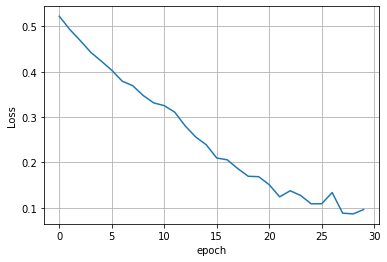

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

k = np.arange(30)
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.grid()   
plt.plot(k, hist) 
plt.show()

In [ ]:
def predict(model, data_loader):
    output = []
    model.eval()
    with torch.no_grad():
        for x_batch, labels_batch in data_loader:
            preds = model(x_batch)
            pred_labels = torch.argmax(preds, axis=1)
            output.append(pred_labels.cpu().numpy())
    return np.hstack(output)

In [ ]:
pred_labels = predict(model, train_loader)
pred_labels_test = predict(model, test_loader)
print("Значение метрики на тренировочной выборке ", matthews_corrcoef(train_cola_labels.values, pred_labels))
print("Значение метрики на тестовой выборке ", matthews_corrcoef(test_cola_labels.values, pred_labels_test))

Значение метрики на тренировочной выборке  0.7664243336557055
Значение метрики на тестовой выборке  0.3927212020089861


Problem: overfitting! We don't get profit for test metric using complex classifier. Solution: correction of parameters for whole model, not only for classifier

## BERT Fine-tuning 

In [ ]:
train_cola_data, val_cola_data, train_cola_labels, val_cola_labels = train_test_split(train_cola_data, train_cola_labels, train_size=0.9)

In [ ]:
tokenized_train = train_cola_data.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
tokenized_val = val_cola_data.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [ ]:
# padding
padded_train_data = add_padding(tokenized_train)
print(padded_train_data.shape)
# attention mask
mask_train = (padded_train_data > 0).astype(int)
print(mask_train.shape)

(5540, 47)
(5540, 47)


In [ ]:
# padding
padded_val_data = add_padding(tokenized_val)
print(padded_val_data.shape)
# attention mask
mask_val = (padded_val_data > 0).astype(int)
print(mask_val.shape)

(616, 40)
(616, 40)


In [ ]:
model = ppb.BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 2, 
                                                          output_attentions = False,output_hidden_states = False)
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
print("Total of model parameters", len(list(model.parameters())))

Total of model parameters 201


Hyperparameters values(lr, total of epoch) are recommended in Hugging Face tutorials

In [ ]:
train_losses = []
val_losses = []
N_train = padded_train_data.shape[0]
N_val = padded_val_data.shape[0]
batch_size = 32
optimizer = ppb.AdamW(model.parameters(), lr=2e-5)


for epoch in range(4):
    model.train()
    loss_epoch = 0
    metric_epoch = 0
    for i in range(0, N_train, batch_size):
        model.zero_grad() 
        x_batch = torch.tensor(padded_train_data[i:i+batch_size]).to(device)
        mask_batch = torch.tensor(mask_train[i:i+batch_size]).to(device)
        labels_batch = torch.tensor(train_cola_labels.values[i:i+batch_size]).to(device) 
        loss = model(x_batch, attention_mask=mask_batch, labels=labels_batch).loss
        logits = model(x_batch, attention_mask=mask_batch, labels=labels_batch).logits

        loss_epoch += loss.item()

        pred_labels = torch.argmax(logits, dim=1)
        pred_labels = pred_labels.detach().cpu().numpy()
        true_labels = train_cola_labels.values[i:i+batch_size]
        metric_epoch += matthews_corrcoef(pred_labels, true_labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    n_batches = N_train // batch_size
    print("Average train loss ", epoch, "epoch: ", loss_epoch / n_batches)
    print("Average train matthews_corrcoef ", epoch, "epoch", metric_epoch / n_batches)          

    model.eval()
    loss_epoch = 0
    metric_epoch = 0
    for i in range(0, N_val, batch_size):
        x_batch = torch.tensor(padded_val_data[i:i+batch_size]).to(device)
        mask_batch = torch.tensor(mask_val[i:i+batch_size]).to(device)
        labels_batch = torch.tensor(val_cola_labels.values[i:i+batch_size]).to(device) 
        with torch.no_grad():
            loss = model(x_batch, attention_mask=mask_batch, labels=labels_batch).loss
            logits = model(x_batch, attention_mask=mask_batch, labels=labels_batch).logits
            loss_epoch += loss.item()

            pred_labels = torch.argmax(logits, dim=1)
            pred_labels = pred_labels.detach().cpu().numpy()
            true_labels = val_cola_labels.values[i:i+batch_size]
            metric_epoch += matthews_corrcoef(pred_labels, true_labels)

    n_batches = N_val // batch_size
    print("Average val loss ", epoch, "epoch: ", loss_epoch / n_batches)
    print("Average  val matthews_corrcoef ", epoch, "epoch", metric_epoch / n_batches) 

Average train loss  0 epoch:  0.526937290595446
Average train matthews_corrcoef  0 epoch 0.3028175685796353
Average val loss  0 epoch:  0.4476292282342911
Average  val matthews_corrcoef  0 epoch 0.5500275831657288
Average train loss  1 epoch:  0.33422032287182835
Average train matthews_corrcoef  1 epoch 0.6691552809149051
Average val loss  1 epoch:  0.45297014438792277
Average  val matthews_corrcoef  1 epoch 0.6313707210939111
Average train loss  2 epoch:  0.21864579697650982
Average train matthews_corrcoef  2 epoch 0.8251818284829715
Average val loss  2 epoch:  0.5856435067559543
Average  val matthews_corrcoef  2 epoch 0.5710632784448405
Average train loss  3 epoch:  0.18496821742138767
Average train matthews_corrcoef  3 epoch 0.8660450737358011
Average val loss  3 epoch:  0.5852166006439611
Average  val matthews_corrcoef  3 epoch 0.628697527585067


Comparison of train and validation metrics proved that overfitting decreased, perfomance of the model improved

In [ ]:
model.eval()
N_test = len(padded_test_data)
n_batch = N_test // batch_size 
total_metric = 0

for i in range(0, N_test, batch_size):
      x_batch = torch.tensor(padded_test_data[i:i+batch_size]).to(device)
      mask_batch = torch.tensor(mask_test[i:i+batch_size]).to(device)
      labels_batch = torch.tensor(test_cola_labels.values[i:i+batch_size]).to(device) 
      with torch.no_grad():
          logits = model(x_batch, attention_mask=mask_batch).logits
          pred_labels = torch.argmax(logits, dim=1)
          pred_labels = pred_labels.detach().cpu().numpy()
          true_labels = test_cola_labels.values[i:i+batch_size]
          total_metric += matthews_corrcoef(pred_labels, true_labels)
print("Average metric value on the test set:", total_metric / n_batch)

Average metric value on the test set: 0.5594159662907257
